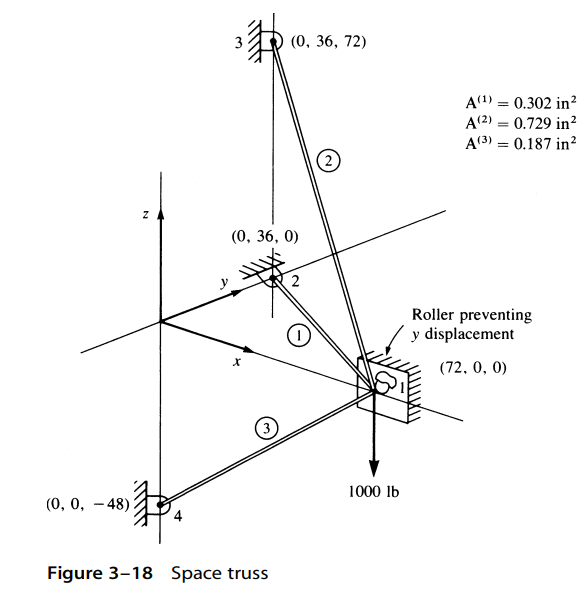

In [1]:
import numpy as np 
import pandas as pd 

creating nodes

In [2]:
columns = ['coordinate_x','coordinate_y','coordinate_z','displacement_x','displacement_y','displacement_z','load_x','load_y','load_z']
data = [[72,0,0,np.nan,0,np.nan,0,0,-1000],
        [0,36,0,0,0,0,np.nan,np.nan,np.nan],
        [0,36,72,0,0,0,np.nan,np.nan,np.nan],
        [0,0,-48,0,0,0,np.nan,np.nan,np.nan]]
nodes = pd.DataFrame(data,columns=columns)
nodes

,coordinate_x,coordinate_y,coordinate_z,displacement_x,displacement_y,displacement_z,load_x,load_y,load_z
0,72,0,0,NaN,0,NaN,0.0,0.0,-1000.0
1,0,36,0,0.0,0,0.0,NaN,NaN,NaN
2,0,36,72,0.0,0,0.0,NaN,NaN,NaN
3,0,0,-48,0.0,0,0.0,NaN,NaN,NaN


creating elements

In [3]:
columns = ['start','end','area','material']
data = [[0,1,0.302,1.2e6],
        [0,2,0.729,1.2e6],
        [0,3,0.187,1.2e6]]
elements = pd.DataFrame(data,columns=columns)
elements

,start,end,area,material
0,0,1,0.302,1200000.0
1,0,2,0.729,1200000.0
2,0,3,0.187,1200000.0


In [4]:
def compute(e):
    start = e['start']
    end = e['end']

    startX = nodes.loc[start,'coordinate_x']
    endX = nodes.loc[end,'coordinate_x']
    deltaX = endX - startX

    startY = nodes.loc[start,'coordinate_y']
    endY = nodes.loc[end,'coordinate_y']
    deltaY = endY - startY

    startZ = nodes.loc[start,'coordinate_z']
    endZ = nodes.loc[end,'coordinate_z']
    deltaZ = endZ - startZ

    length = np.sqrt(deltaX**2 + deltaY**2 + deltaZ**2)
    length

    stiffness = e['area']*e['material']/length

    cx = deltaX/length
    cy = deltaY/length
    cz = deltaZ/length
    x = np.array([[cx*cx, cx*cy, cx*cz],
                 [cy*cx, cy*cy, cy*cz],
                 [cz*cx, cz*cy, cz*cz]])
    k = np.array([[cx*cx, cx*cy, cx*cz, -cx*cx, -cx*cy, -cx*cz],
                  [cy*cx, cy*cy, cy*cz, -cy*cx, -cy*cy, -cy*cz],
                  [cz*cx, cz*cy, cz*cz, -cz*cx, -cz*cy, -cz*cz],
                  [-cx*cx, -cx*cy, -cx*cz, cx*cx, cx*cy, cx*cz],
                  [-cy*cx, -cy*cy, -cy*cz, cy*cx, cy*cy, cy*cz],
                  [-cz*cx, -cz*cy, -cz*cz, cz*cx, cz*cy, cz*cz],]).round(5)
    return length, stiffness, k, cx, cy, cz
elements[['length','stiffness','k','Cx','Cy','Cz']] = elements.apply(compute,axis=1,result_type='expand')
elements

,start,end,area,material,length,stiffness,k,Cx,Cy,Cz
0,0,1,0.302,1200000.0,80.498447,4501.950195,"[[0.8, -0.4, -0.0, -0.8, 0.4, 0.0], [-0.4, 0.2...",-0.894427,0.447214,0.000000
1,0,2,0.729,1200000.0,108.000000,8100.000000,"[[0.44444, -0.22222, -0.44444, -0.44444, 0.222...",-0.666667,0.333333,0.666667
2,0,3,0.187,1200000.0,86.533231,2593.223417,"[[0.69231, -0.0, 0.46154, -0.69231, 0.0, -0.46...",-0.832050,0.000000,-0.554700


In [5]:
def compute_globalK(element):
    N = len(nodes)
    indices = np.arange(N*3)
    indices = indices.reshape(-1,3)

    K = np.zeros([N*3,N*3])
    start = element['start']
    end = element['end']
    indices = np.hstack([indices[start],indices[end]])
    K[np.ix_(indices,indices)] = element['stiffness']*element['k']
    return K
K = elements.apply(compute_globalK, axis=1).sum()
K.round()

array([[ 8997., -3601., -2403., -3602.,  1801.,     0., -3600.,  1800.,
         3600., -1795.,     0., -1197.],
       [-3601.,  1800.,  1800.,  1801.,  -900.,     0.,  1800.,  -900.,
        -1800.,     0.,     0.,     0.],
       [-2403.,  1800.,  4398.,     0.,     0.,     0.,  3600., -1800.,
        -3600., -1197.,     0.,  -798.],
       [-3602.,  1801.,     0.,  3602., -1801.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.],
       [ 1801.,  -900.,     0., -1801.,   900.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.],
       [-3600.,  1800.,  3600.,     0.,     0.,     0.,  3600., -1800.,
        -3600.,     0.,     0.,     0.],
       [ 1800.,  -900., -1800.,     0.,     0.,     0., -1800.,   900.,
         1800.,     0.,     0.,     0.],
       [ 3600., -1800., -3600.,     0.,     0.,     0., -3600.,  1800.,
         3600.,     0., 

In [6]:
def partition_k(K, A, B):
    KAA = K[np.ix_(A,A)]
    KAB = K[np.ix_(A,B)]
    KBA = K[np.ix_(B,A)]
    KBB = K[np.ix_(B,B)]
    return KAA, KAB, KBA, KBB

U = nodes[['displacement_x','displacement_y','displacement_z']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['load_x','load_y','load_z']].to_numpy()
P = P.ravel()
B = np.isnan(P)

KAA, KAB, KBA, KBB = partition_k(K, A, B)

In [7]:
# Known displacement, UB
UB = U[B]
# Known load, PA
PA = P[A]

UA = np.dot(np.linalg.inv(KAA),(PA - np.dot(KAB,UB)))
U[A] = UA

PB = np.dot(KBA,UA) + np.dot(KBB,UB)
P[B] = PB

In [8]:
results = nodes.copy()
results[['displacement_x','displacement_y','displacement_z']] = U.reshape(-1,3)
results[['load_x','load_y','load_z']] = P.reshape(-1,3)
results

,coordinate_x,coordinate_y,coordinate_z,displacement_x,displacement_y,displacement_z,load_x,load_y,load_z
0,72,0,0,-0.071114,0.0,-0.266241,0.000000,0.000000,-1000.000000
1,0,36,0,0.000000,0.0,0.000000,256.120779,-128.060389,0.000000
2,0,36,72,0.000000,0.0,0.000000,-702.449692,351.224846,702.449692
3,0,0,-48,0.000000,0.0,0.000000,446.328914,0.000000,297.550308


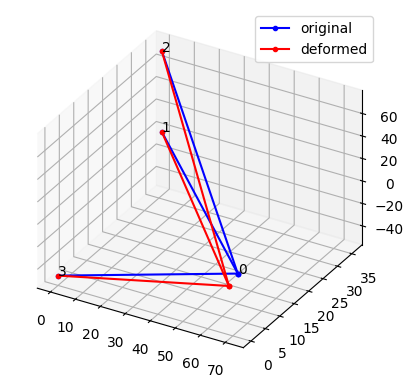

In [9]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
factor = 50
results['deformed_x'] = results['coordinate_x'] + factor*results['displacement_x']
results['deformed_y'] = results['coordinate_y'] + factor*results['displacement_y']
results['deformed_z'] = results['coordinate_z'] + factor*results['displacement_z']
#results.loc[4] = results.loc[0] # adding a new row with values as first row
ax = plt.axes(projection='3d',proj_type = 'ortho')

def original_fig():
    ax.plot3D(results.loc[0:1,'coordinate_x'],results.loc[0:1,'coordinate_y'],results.loc[0:1,'coordinate_z'],'b.-', label = 'original')
    ax.plot3D(results.loc[[0,2],'coordinate_x'],results.loc[[0,2],'coordinate_y'],results.loc[[0,2],'coordinate_z'],'b.-')
    ax.plot3D(results.loc[[0,3],'coordinate_x'],results.loc[[0,3],'coordinate_y'],results.loc[[0,3],'coordinate_z'],'b.-')
    for i in range(4):
        ax.text(results.loc[i,'coordinate_x'],results.loc[i,'coordinate_y'],results.loc[i,'coordinate_z'],'{}'.format(i))
original_fig()

def deformed_fig():
    ax.plot3D(results.loc[0:1,'deformed_x'],results.loc[0:1,'deformed_y'],results.loc[0:1,'deformed_z'],'r.-', label = 'deformed')
    ax.plot3D(results.loc[[0,2],'deformed_x'],results.loc[[0,2],'deformed_y'],results.loc[[0,2],'deformed_z'],'r.-')
    ax.plot3D(results.loc[[0,3],'deformed_x'],results.loc[[0,3],'deformed_y'],results.loc[[0,3],'deformed_z'],'r.-')
deformed_fig()

plt.legend()
# plt.axis('off')
plt.show()

xz plane

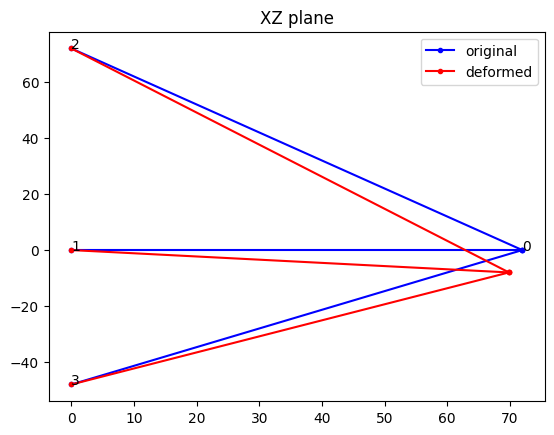

In [10]:
factor = 30
results['deformed_x'] = results['coordinate_x'] + factor*results['displacement_x']
results['deformed_z'] = results['coordinate_z'] + factor*results['displacement_z']
#results.loc[4] = results.loc[0] # adding a new row with values as first row

def original_fig():
    plt.plot(results.loc[0:1,'coordinate_x'],results.loc[0:1,'coordinate_z'],'b.-', label = 'original')
    plt.plot(results.loc[[0,2],'coordinate_x'],results.loc[[0,2],'coordinate_z'],'b.-')
    plt.plot(results.loc[[0,3],'coordinate_x'],results.loc[[0,3],'coordinate_z'],'b.-')
    for i in range(4):
        plt.text(results.loc[i,'coordinate_x'],results.loc[i,'coordinate_z'],'{}'.format(i))
original_fig()

def deformed_fig():
    plt.plot(results.loc[0:1,'deformed_x'],results.loc[0:1,'deformed_z'],'r.-', label = 'deformed')
    plt.plot(results.loc[[0,2],'deformed_x'],results.loc[[0,2],'deformed_z'],'r.-')
    plt.plot(results.loc[[0,3],'deformed_x'],results.loc[[0,3],'deformed_z'],'r.-')
deformed_fig()

plt.legend()
plt.title('XZ plane')
# plt.axis('off')
plt.show()

xy plane

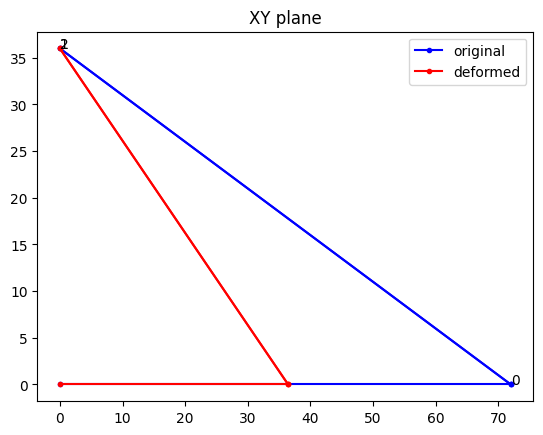

In [11]:
factor = 500
results['deformed_x'] = results['coordinate_x'] + factor*results['displacement_x']
results['deformed_y'] = results['coordinate_y'] + factor*results['displacement_y']
#results.loc[4] = results.loc[0] # adding a new row with values as first row

def original_fig():
    plt.plot(results.loc[0:1,'coordinate_x'],results.loc[0:1,'coordinate_y'],'b.-', label = 'original')
    plt.plot(results.loc[[0,2],'coordinate_x'],results.loc[[0,2],'coordinate_y'],'b.-')
    plt.plot(results.loc[[0,3],'coordinate_x'],results.loc[[0,3],'coordinate_y'],'b.-')
    #plt.text(results.loc[0,'coordinate_x'],results.loc[0,'coordinate_y'],'0')
    
    for i in range(3):
        plt.text(results.loc[i,'coordinate_x'],results.loc[i,'coordinate_y'],'{}'.format(i))
original_fig()

def deformed_fig():
    plt.plot(results.loc[0:1,'deformed_x'],results.loc[0:1,'deformed_y'],'r.-', label = 'deformed')
    plt.plot(results.loc[[0,2],'deformed_x'],results.loc[[0,2],'deformed_y'],'r.-')
    plt.plot(results.loc[[0,3],'deformed_x'],results.loc[[0,3],'deformed_y'],'r.-')
deformed_fig()

plt.legend()
plt.title('XY plane')
# plt.axis('off')
plt.show()

computation of stress

In [12]:
def compute_stress(element):
    N = len(nodes)
    indices = np.arange(N*3)
    indices = indices.reshape(-1,3)
    start = element['start']
    end = element['end']
    indices = np.hstack([indices[start],indices[end]])
    d = U[np.ix_(indices)]
    cx,cy,cz = element['Cx'],element['Cy'],element['Cz']
    C = (element['material']/element['length'])*np.array([-cx, -cy, -cz, cx, cy, cz])
    stress = np.dot(C,d)
    return stress
elements['stress'] = elements.apply(compute_stress,axis=1)
elements

,start,end,area,material,length,stiffness,k,Cx,Cy,Cz,stress
0,0,1,0.302,1200000.0,80.498447,4501.950195,"[[0.8, -0.4, -0.0, -0.8, 0.4, 0.0], [-0.4, 0.2...",-0.894427,0.447214,0.000000,-948.184555
1,0,2,0.729,1200000.0,108.000000,8100.000000,"[[0.44444, -0.22222, -0.44444, -0.44444, 0.222...",-0.666667,0.333333,0.666667,1445.384191
2,0,3,0.187,1200000.0,86.533231,2593.223417,"[[0.69231, -0.0, 0.46154, -0.69231, 0.0, -0.46...",-0.832050,0.000000,-0.554700,-2868.549768
